In [1]:
from __future__ import division
from collections import defaultdict
from pathlib import Path
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from nltk.stem.porter import *
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import random, math, re, sys, csv, string, nltk, unicodedata
import pickle
import numpy as np
import pandas as pd
%matplotlib inline

data_list = ['apache','openintents','zxing','org.eclipse.mat']

'''
Function to generate csv data file for specfic dataset. 
'''
def generate_csv_file(dataset):
    isBugFix = set()
    with open('data_raw/' + dataset + '/links.txt') as fs:
        for line in fs:
            cells = line.split("\t")
            if len(cells) > 0 and cells[0] != "":
                isBugFix.add(int(cells[1]))
    fs.close()

    rows = [['is_bug_fix', 'revisionNo', 'message']]
    with open('data_raw/' + dataset + '/changeLogs.txt', encoding = "ISO-8859-1") as fs: 
        for line in fs:
            cells = line.split("\t")
            if len(cells) > 0 and cells[0] != "":
                if int(cells[0]) in isBugFix:
                    rows.append([1, cells[0], cells[3]])
                else:
                    rows.append([0, cells[0], cells[3]])
    fs.close()

    with open('data_processed/' + dataset+'.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
        csvFile.close()

'''
Generate csv data file if not already exist.
'''
def collect_data():
    for data in data_list:
        my_file = Path('data_processed/' + data + '.csv')
        if not my_file.is_file():
            generate_csv_file(data)

In [2]:
def load_dictionary():
    corrective_dict = defaultdict(int)
    with open('dictionary/corrective.txt') as fs:
        for line in fs:
            line = re.sub(r'([ \n\r\t]|#.*)', "", line)
            cells = line.split(",")
            for x in cells:
                if len(x) > 0:
                    #print(x)
                    if (x[-1] is ')'):
                        corrective_dict[x[:-3]] = int(x[-2])
                    else:
                        corrective_dict[x] = 1
    fs.close()
    #print(corrective_dict)


    adaptive_dict = defaultdict(int)
    with open('dictionary/adaptive.txt') as fs:
        for line in fs:
            line = re.sub(r'([ \n\r\t]|#.*)', "", line)
            cells = line.split(",")
            for x in cells:
                if len(x) > 0:
                    #print(x)
                    if (x[-1] is ')'):
                        adaptive_dict[x[:-3]] = int(x[-2])
                    else:
                        adaptive_dict[x] = 1
    fs.close()
    
    perfective_dict = defaultdict(int)
    with open('dictionary/perfective.txt') as fs:
        for line in fs:
            line = re.sub(r'([ \n\r\t]|#.*)', "", line)
            cells = line.split(",")
            for x in cells:
                if len(x) > 0:
                    #print(x)
                    if (x[-1] is ')'):
                        perfective_dict[x[:-3]] = int(x[-2])
                    else:
                        perfective_dict[x] = 1
    fs.close()
        

    blacklist_dict = defaultdict(int)
    with open('dictionary/blacklist.txt') as fs:
        for line in fs:
            line = re.sub(r'([ \n\r\t]|#.*)', "", line)
            cells = line.split(",")
            for x in cells:
                if len(x) > 0:
                    #print(x)
                    if (x[-1] is ')'):
                        blacklist_dict[x[:-3]] = int(x[-2])
                    else:
                        blacklist_dict[x] = 1
    fs.close()
    
    return corrective_dict,adaptive_dict,perfective_dict,blacklist_dict


## Select which dataset to use

In [3]:
collect_data()

data = 'apache'
df = pd.read_csv("data_processed/" + data + ".csv")

In [4]:
df

,is_bug_fix,revisionNo,message
0,0,76294,"At long last, create httpd directory. ---- Add..."
1,0,76295,Import HTTP Server Repositories ---- Added : /...
2,0,76296,Import HTTP Server Repositories ---- Added : /...
3,0,76297,Import HTTP Server Repositories ---- Added : /...
4,0,76298,Import HTTP Server Repositories ---- Added : /...
5,0,76299,Import HTTP Server Repositories ---- Added : /...
6,0,76300,Import HTTP Server Repositories ---- Added : /...
7,0,76301,Import HTTP Server Repositories ---- Added : /...
8,0,76302,Import HTTP Server Repositories ---- Added : /...
9,0,76303,Import HTTP Server Repositories ---- Added : /...


In [5]:
df.describe()

,is_bug_fix,revisionNo
count,43867.000000,43867.000000
mean,0.022226,227561.134201
std,0.147420,233239.367837
min,0.000000,76294.000000
25%,0.000000,87286.500000
50%,0.000000,98301.000000
75%,0.000000,329234.000000
max,1.000000,899841.000000


In [6]:
df.columns

Index(['is_bug_fix', 'revisionNo', 'message'], dtype='object')

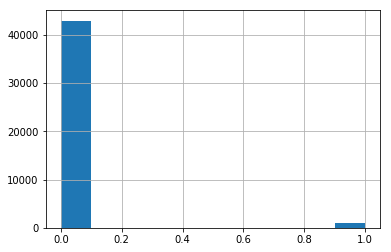

In [7]:
df['is_bug_fix'].hist()

In [8]:
messages = df.message

## Noise Removal

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

## Tokenization

In [10]:
def tokenize(text):
    words = nltk.word_tokenize(text)
    return words

## Normalization

In [11]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

## Baseline: majority dictionary vote

In [12]:
corrective_dict,adaptive_dict,perfective_dict,blacklist_dict = load_dictionary()

predict = []

for m in messages:
    m = denoise_text(m)
    tokens = tokenize(m)
    normalized_tokens = normalize(tokens)
    
    corrective_vote = 0
    adaptive_vote = 0
    perfective_vote = 0
    blacklist_vote = 0
    
    for word in normalized_tokens:
        if word in corrective_dict: 
            corrective_vote+=corrective_dict[word]
        if word in adaptive_dict: 
            adaptive_vote+=adaptive_dict[word]
        if word in perfective_dict: 
            perfective_vote+=perfective_dict[word]
        if word in blacklist_dict: 
            blacklist_vote+=blacklist_dict[word]
            
    if corrective_vote > adaptive_vote and corrective_vote > perfective_vote and corrective_vote > blacklist_vote:
        predict.append(1)
    else:
        predict.append(0)
    
y_preds = np.array(predict)
y_true = df.values[:,0].astype('int')

In [13]:
target_names = ['not bug-fix', 'bug-fix']
print(classification_report(y_true, y_preds, target_names=target_names))

              precision    recall  f1-score   support

 not bug-fix       0.98      0.88      0.93     42892
     bug-fix       0.06      0.35      0.11       975

   micro avg       0.87      0.87      0.87     43867
   macro avg       0.52      0.62      0.52     43867
weighted avg       0.96      0.87      0.91     43867



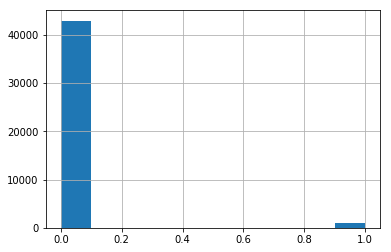

In [14]:
#True distribution
df["is_bug_fix"].hist()

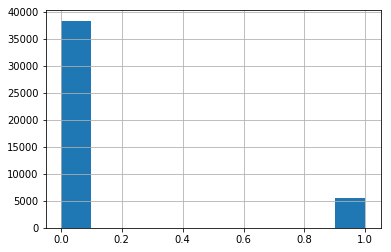

In [15]:
pd.Series(y_preds).hist()

## Proposed approachs 

In [16]:
messages = df.message

In [17]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    return parsed_text

def tokenize(text):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    tokens = [stemmer.stem(t) for t in text.split()]
    return tokens

def basic_tokenize(text):
    """Same as tokenize but without the stemming"""
    text = " ".join(re.split("[^a-zA-Z.,!?]*", text.lower())).strip()
    return text.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(messages).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
#Get POS tags for tweets and save as a string
text_tags = []
for t in messages:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    text_tags.append(tag_str)

In [ ]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [ ]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(text_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *

#Now get other features
sentiment_analyzer = VS()

def other_features(text):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores"""
    sentiment = sentiment_analyzer.polarity_scores(text)
    
    words = preprocess(text) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(text)
    num_terms = len(text.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(messages):
    feats=[]
    for t in messages:
        feats.append(other_features(t))
    return np.array(feats)

In [ ]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound"]

In [ ]:
feats = get_feature_array(messages)

In [ ]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [ ]:
M.shape

(43867, 15013)

In [ ]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

X = pd.DataFrame(M)
y = df['is_bug_fix'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

# Proposed approach one: Logistic Regression

In [ ]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [ ]:
param_grid = [{}] # Optionally add parameters here

In [ ]:
grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [ ]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  41.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   46.3s remaining:    0.0s


[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  39.6s
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  39.7s
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  45.3s
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  35.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4285
           1       0.35      0.87      0.50       102

   micro avg       0.96      0.96      0.96      4387
   macro avg       0.67      0.92      0.74      4387
weighted avg       0.98      0.96      0.97      4387



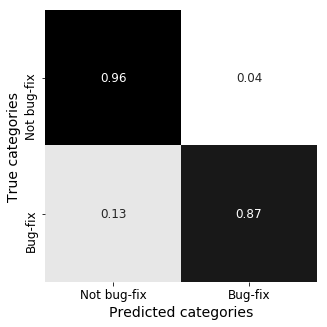

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn

confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Not bug-fix','Bug-fix']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
plt.savefig('confusion.pdf')

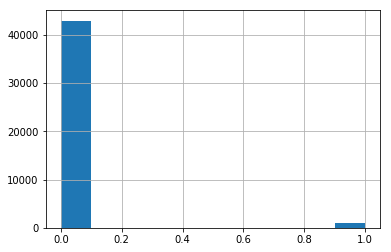

In [ ]:
#True distribution
y.hist()

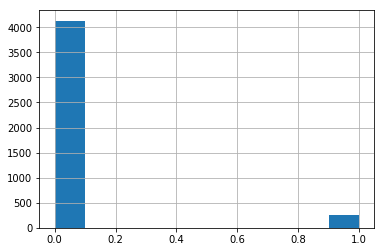

In [ ]:
pd.Series(y_preds).hist()

## Oversampling

## LR + SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.1min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.4min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.6min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.3min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.3min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.0min finished
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4285
           1       0.35      0.84      0.49       102

   micro avg       0.96      0.96      0.96      4387
   macro avg       0.67      0.90      0.74      4387
weighted avg       0.98      0.96      0.97      4387



## LR + ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

X_train_res, y_train_res = ADASYN().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.4min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.8min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.3min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min finished
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4285
           1       0.42      0.80      0.55       102

   micro avg       0.97      0.97      0.97      4387
   macro avg       0.71      0.89      0.77      4387
weighted avg       0.98      0.97      0.97      4387



## LR + RandomOverSampler

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.5min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.5min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.3min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.3min finished
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4285
           1       0.34      0.85      0.48       102

   micro avg       0.96      0.96      0.96      4387
   macro avg       0.67      0.91      0.73      4387
weighted avg       0.98      0.96      0.97      4387



## LR + BorderlineSMOTE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

X_train_res, y_train_res = BorderlineSMOTE().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  57.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total= 1.0min
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  58.3s
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  58.0s
[CV]  ................................................................


/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] ................................................. , total=  49.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.9min finished
/Users/weijia_li/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4285
           1       0.42      0.80      0.55       102

   micro avg       0.97      0.97      0.97      4387
   macro avg       0.71      0.89      0.77      4387
weighted avg       0.98      0.97      0.97      4387



## Combination of over- and under-sampling

## SMOTEENN

In [ ]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## LR + SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## Under Sampling

## LR + ClusterCentroids

In [ ]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)
X_train_res, y_train_res = cc.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## LR + CondensedNearestNeighbour

In [ ]:
from imblearn.under_sampling import CondensedNearestNeighbour

X_train_res, y_train_res = CondensedNearestNeighbour().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## EditedNearestNeighbours

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

X_train_res, y_train_res = EditedNearestNeighbours().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## RepeatedEditedNearestNeighbours

In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

X_train_res, y_train_res = RepeatedEditedNearestNeighbours().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## AllKNN

In [ ]:
from imblearn.under_sampling import AllKNN

X_train_res, y_train_res = AllKNN().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## InstanceHardnessThreshold

In [ ]:
from imblearn.under_sampling import InstanceHardnessThreshold

X_train_res, y_train_res = InstanceHardnessThreshold().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## NearMiss

In [ ]:
from imblearn.under_sampling import NearMiss

# version 1
nm1 = NearMiss(version=1)
X_train_res, y_train_res = nm1.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

In [ ]:
# version 2
nm2 = NearMiss(version=2)
X_train_res, y_train_res = nm2.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

In [ ]:
# version 3
nm3 = NearMiss(version=3)
X_train_res, y_train_res = nm3.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## NeighbourhoodCleaningRule

In [ ]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

X_train_res, y_train_res = NeighbourhoodCleaningRule().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## OneSidedSelection

In [ ]:
from imblearn.under_sampling import OneSidedSelection

X_train_res, y_train_res = OneSidedSelection().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## RandomUnderSampler

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)

## TomekLinks

In [ ]:
from imblearn.under_sampling import TomekLinks

X_train_res, y_train_res = TomekLinks().fit_resample(X_train, y_train)

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train_res, y_train_res), 
                           verbose=2)

model = grid_search.fit(X_train_res, y_train_res)

y_preds = model.predict(X_test)
report = classification_report( y_test, y_preds )
print(report)